# First thing first: Lets import the necessary libraries

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Import FashionMNIST dataset from OpenML



In [ ]:
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True)

X = X.to_numpy()
y = y.astype(int).to_numpy()

print("X shape:", X.shape)


X shape: (70000, 784)


 I check the data shape. I have 70.000 images and 784 comes from flattened 28x28 pixels.

Our best friend while working on Linear Models: SKLEARN

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.1, random_state=0, stratify=y
)

In [ ]:
print("X_train size:", X_train.shape)
print("X_val size:", X_val.shape)

X_train size: (7000, 784)
X_val size: (63000, 784)


##########

# Approach 1: Closed-form Solution

In [ ]:
n_samples, n_features = X_train.shape
n_classes = len(np.unique(y_train))

# Closed-Form Linear Solution ---
W = np.zeros((n_features, n_classes))  # each column is a weight vector for one class

start = time.time()

XtX_inv = np.linalg.inv(X_train.T @ X_train)  # precompute inverse
for k in range(n_classes):
    y_binary = (y_train == k).astype(int)     # 1 if class k, else 0
    W[:, k] = XtX_inv @ (X_train.T @ y_binary)
end = time.time()
train_time_closed = end-start
print("Training time (closed-form):", end - start, "seconds")

# --- Compute predictions ---
scores_val = X_val @ W                 # shape: (n_val_samples, n_classes)
y_pred_val = np.argmax(scores_val, axis=1)  # pick class with highest score

scores_train = X_train @ W
y_pred_train = np.argmax(scores_train, axis=1)

# --- Compute accuracy ---
train_acc_closed = np.mean(y_pred_train == y_train)
val_acc_closed = np.mean(y_pred_val == y_val)

print("Training accuracy:", train_acc_closed)
print("Validation accuracy:", val_acc_closed)

Training time (closed-form): 57.57658934593201 seconds
Training accuracy: 0.8688571428571429
Validation accuracy: 0.792984126984127


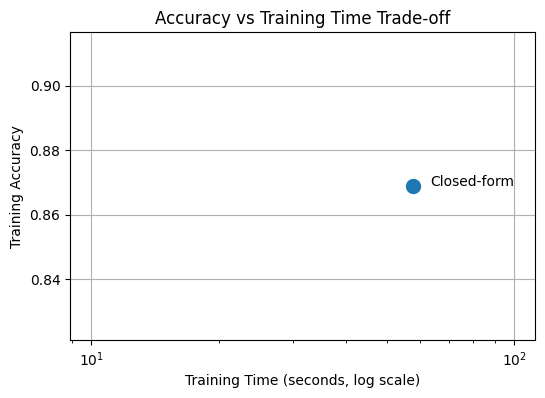

In [ ]:
# Plot 1: Train Accuracy
plt.figure(figsize=(6, 4))
methods = ["Closed-form"]

accuracies = [train_acc_closed,]
times = [train_time_closed]
for method, acc, t in zip(methods, accuracies, times):
    plt.scatter(t, acc, s=100)
    plt.text(t * 1.1, acc, method)

plt.xscale("log")
plt.xlabel("Training Time (seconds, log scale)")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Training Time Trade-off")
plt.grid(True)
plt.show()

##########

# Approach 2: Gradient Descent

In [ ]:
print("\n--- SGDClassifier ---" "It is linear classifier with gradient solver")

clf = SGDClassifier(
    loss="log_loss",
    random_state=42)

start = time.time()
clf.fit(X_train, y_train)
end = time.time()
train_time_sgd = end-start
print("Training time:", end - start)

train_acc_sgd = clf.score(X_train, y_train)
val_acc_sgd = clf.score(X_val, y_val)


print("Training accuracy:", train_acc_sgd)
print("Validation accuracy:", val_acc_sgd)


--- SGDClassifier ---It is linear classifier with gradient solver
Training time: 10.284642457962036
Training accuracy: 0.8801428571428571
Validation accuracy: 0.7798888888888889


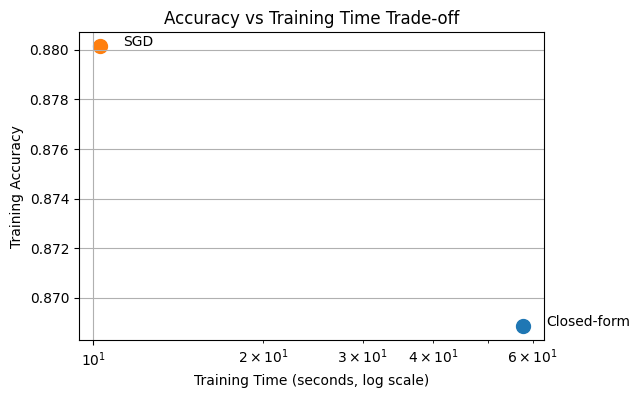

In [ ]:
plt.figure(figsize=(6, 4))
methods = ["Closed-form", "SGD"]

accuracies = [train_acc_closed, train_acc_sgd,

]
times = [train_time_closed, train_time_sgd]
for method, acc, t in zip(methods, accuracies, times):
    plt.scatter(t, acc, s=100)
    plt.text(t * 1.1, acc, method)

plt.xscale("log")
plt.xlabel("Training Time (seconds, log scale)")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Training Time Trade-off")
plt.grid(True)
plt.show()

##########

# Approach 3: Second-order Solution

In [ ]:
print("\n--- LogisticRegression --- It is a linear classifier with a second-order solver")

from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(solver= 'newton-cg',   # quasi-Newton (second-order)       # iterations are expensive but few needed
    n_jobs=-1
)

start = time.time()
clf_lr.fit(X_train, y_train)
end = time.time()
train_time_newton = end-start
print("Training time:", end - start)

train_acc_newton = clf_lr.score(X_train, y_train)
val_acc_newton = clf_lr.score(X_val, y_val)

print("Training accuracy:", train_acc_newton)
print("Validation accuracy:", val_acc_newton)



--- LogisticRegression --- It is a linear classifier with a second-order solver
Training time: 62.336347818374634
Training accuracy: 1.0
Validation accuracy: 0.7566825396825397


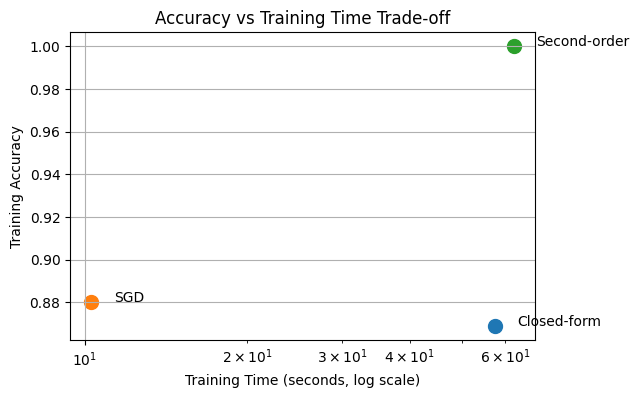

In [ ]:
plt.figure(figsize=(6, 4))
methods = ["Closed-form", "SGD", "Second-order"]

accuracies = [train_acc_closed, train_acc_sgd,train_acc_newton]
times = [train_time_closed, train_time_sgd, train_time_newton]
for method, acc, t in zip(methods, accuracies, times):
    plt.scatter(t, acc, s=100)
    plt.text(t * 1.1, acc, method)

plt.xscale("log")
plt.xlabel("Training Time (seconds, log scale)")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Training Time Trade-off")
plt.grid(True)
plt.show()

# Sklearn offers us a great approach:
L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) approximates Newton's method and gives near-Newton success at gradient-descent cost.


In [ ]:
print("\n--- LogisticRegression --- It is a linear classifier with a second-order solver")

clf_lr = LogisticRegression(solver= 'lbfgs')

start = time.time()
clf_lr.fit(X_train, y_train)
end = time.time()
train_time_lbfgs = end-start
print("Training time:", end - start)

train_acc_lbfgs = clf_lr.score(X_train, y_train)
val_acc_lbfgs = clf_lr.score(X_val, y_val)

print("Training accuracy:", train_acc_lbfgs)
print("Validation accuracy:", val_acc_lbfgs)


--- LogisticRegression --- It is a linear classifier with a second-order solver
Training time: 9.263885259628296
Training accuracy: 0.9031428571428571
Validation accuracy: 0.8171587301587302


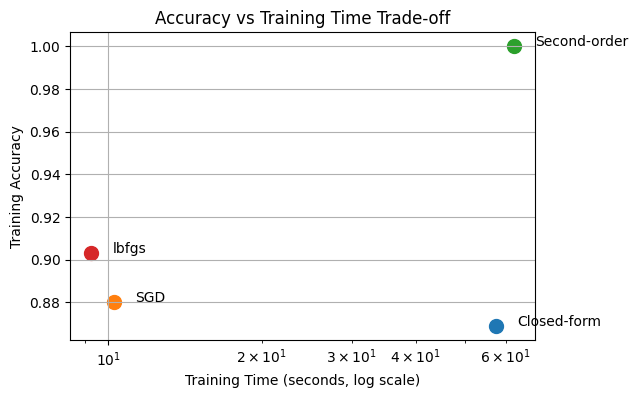

In [ ]:
plt.figure(figsize=(6, 4))
methods = ["Closed-form", "SGD", "Second-order", "lbfgs"]

accuracies = [train_acc_closed, train_acc_sgd,train_acc_newton,train_acc_lbfgs]
times = [train_time_closed, train_time_sgd, train_time_newton, train_time_lbfgs]
for method, acc, t in zip(methods, accuracies, times):
    plt.scatter(t, acc, s=100)
    plt.text(t * 1.1, acc, method)

plt.xscale("log")
plt.xlabel("Training Time (seconds, log scale)")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Training Time Trade-off")
plt.grid(True)
plt.show()

##############

# You have also learned SVMs

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# SVC with linear kernel (dual)
start = time.time()
clf_svc = SVC(kernel='linear')
clf_svc.fit(X_train, y_train)
end = time.time()
train_time_svc= end-start
y_pred_svc = clf_svc.predict(X_val)
y_pred_svc_train = clf_svc.predict(X_train)
val_acc_svc = accuracy_score(y_val, y_pred_svc)
train_acc_svc = accuracy_score(y_train, y_pred_svc_train)


print("SVC (linear kernel) Train accuracy:", train_acc_svc)
print("SVC (linear kernel) Val accuracy:", val_acc_svc)
print("Time taken:", end - start, "seconds")


SVC (linear kernel) Train accuracy: 1.0
SVC (linear kernel) Val accuracy: 0.8013492063492064
Time taken: 8.137063264846802 seconds


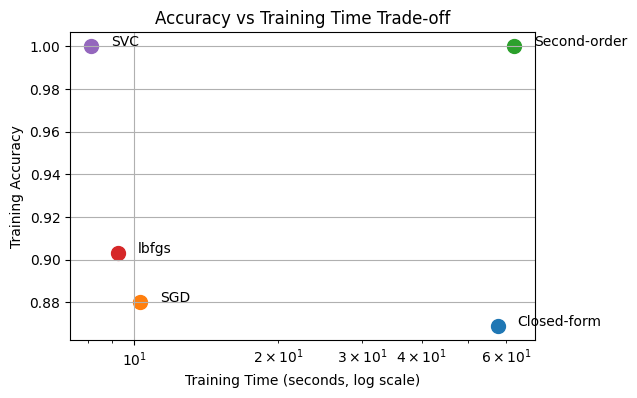

In [ ]:
plt.figure(figsize=(6, 4))
methods = ["Closed-form", "SGD", "Second-order", "lbfgs", "SVC"]

accuracies = [train_acc_closed, train_acc_sgd,train_acc_newton, train_acc_lbfgs, train_acc_svc]
times = [train_time_closed, train_time_sgd, train_time_newton, train_time_lbfgs, train_time_svc]
for method, acc, t in zip(methods, accuracies, times):
    plt.scatter(t, acc, s=100)
    plt.text(t * 1.1, acc, method)

plt.xscale("log")
plt.xlabel("Training Time (seconds, log scale)")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Training Time Trade-off")
plt.grid(True)
plt.show()

# How successfuly these solutions can generalize to unseen data?

So far, we have implemented 5 different solutions for our classification problem. We have compared them in terms of their training accuracy and efficiency. But in real life, we need models that are robust and can generalize to unseen samples. So that is why we have seperated our dataset as training and validation in the beginning. Since our model did not see the validation set for training, we can evaluate each model's robustness on this validation set.

Among, 5 approaches we can take and evaluate most efficient ones which are, SGDClassifier, Logistic Regression with lbfgs solver and SVC.

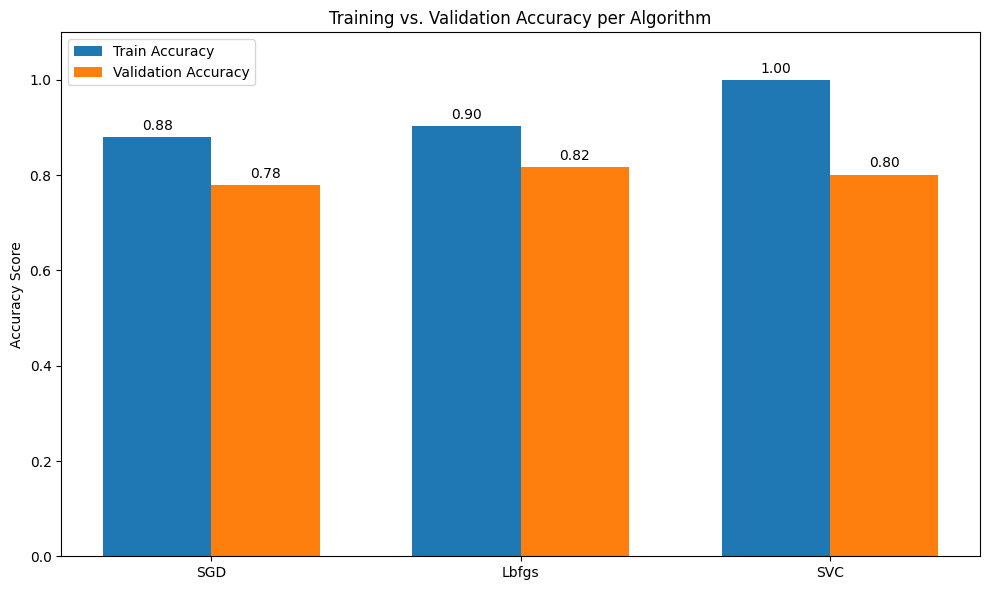

In [ ]:

# 1. Define the algorithms and their performance metrics
# Values are based on our previous discussions of FashionMNIST
algorithms = ['SGD', 'Lbfgs', 'SVC']
train_acc = [train_acc_sgd, train_acc_lbfgs, train_acc_svc]
val_acc = [val_acc_sgd, val_acc_lbfgs, val_acc_svc]

x = np.arange(len(algorithms))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# 2. Create the grouped bar chart
rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='#1f77b4')
rects2 = ax.bar(x + width/2, val_acc, width, label='Validation Accuracy', color='#ff7f0e')

# 3. Add styling and labels
ax.set_ylabel('Accuracy Score')
ax.set_title('Training vs. Validation Accuracy per Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.set_ylim(0, 1.1)  # Set limit slightly above 1.0 for labels
ax.legend()

# 4. Add numerical labels on top of the bars for clarity
def autolabel(rects):
    """Attach a text label above each bar, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('algo_comparison.png')

# What does this gap between train and validation accuracies tell you ?

This means that all the models we have here are overfitting to training data and are not super robust.  

But we actually have learned one approach in the class to prevent overfitting issue!

That is the regularization.

We can take the Logistic Regression model as an example and start working on that for findign the optimum regularization strength.

The C value in the sklearn implementation controls the regularization strength. So we can try range of C values from low to high and try to find sweet spot.

In [ ]:

# Hyperparameter values to try
C_values = [0.00000001, 0.000001, 0.0001, 0.01, 1]

train_accs = []
val_accs = []

for C in C_values:
    clf_lr = LogisticRegression(solver='lbfgs', C=C)

    start = time.time()
    clf_lr.fit(X_train, y_train)
    end = time.time()

    train_acc = clf_lr.score(X_train, y_train)
    val_acc = clf_lr.score(X_val, y_val)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"C={C} | Time={end-start:.3f}s | Train={train_acc:.4f} | Val={val_acc:.4f}")


C=1e-08 | Time=9.142s | Train=0.7531 | Val=0.7478
C=1e-06 | Time=9.387s | Train=0.8771 | Val=0.8328
C=0.0001 | Time=7.419s | Train=0.9057 | Val=0.8223
C=0.01 | Time=9.162s | Train=0.9047 | Val=0.8213
C=1 | Time=10.041s | Train=0.9031 | Val=0.8172


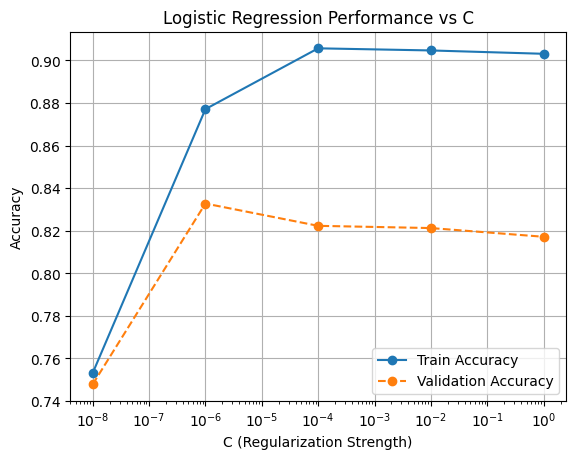

In [ ]:
plt.figure()

plt.plot(C_values, train_accs, marker='o', linestyle='-', label='Train Accuracy')
plt.plot(C_values, val_accs, marker='o', linestyle='--', label='Validation Accuracy')

plt.xscale('log')  # recommended for C
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Performance vs C')
plt.legend()
plt.grid(True)

plt.show()


#################

# Finding the best hyperparameter or model is not enough, we should analyse more and get some insights about our model

We found the optimum strength, now as a data scientist I think it is always good idea to see where your model is struggling.

For example, we can take the best model and do classification on validation set and see which class is hard to predict for our model.



Validation Accuracy: 0.8327777777777777


<Figure size 800x800 with 0 Axes>

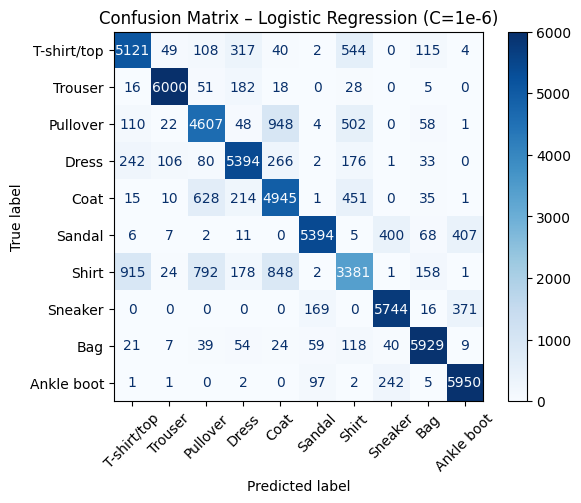

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf_best = LogisticRegression(
    solver="lbfgs",
    C=1e-6,
    n_jobs=-1
)

clf_best.fit(X_train, y_train)

y_val_pred = clf_best.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_acc)



cm = confusion_matrix(y_val, y_val_pred)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Logistic Regression (C=1e-6)")
plt.xticks(rotation=45)
plt.show()


It looks like our model is mostly struggling with classifying Shirt and it confuses it with coat, pullover and tshirt.

 This actually kind of makes sense because all these categories look similar to each other.

 I think this is the real challenge for AI models, when we have very similar looking categories we should make sure that our model is capable
 of distinguishing them successfully.

### Do you remember the Muffin and Chihuahua Example?? :D

More Analysis about regularization: how regularization strength in Logistic Regression affects the model's decision-making process through pixel-level feature contribution analysis on the Fashion-MNIST dataset.

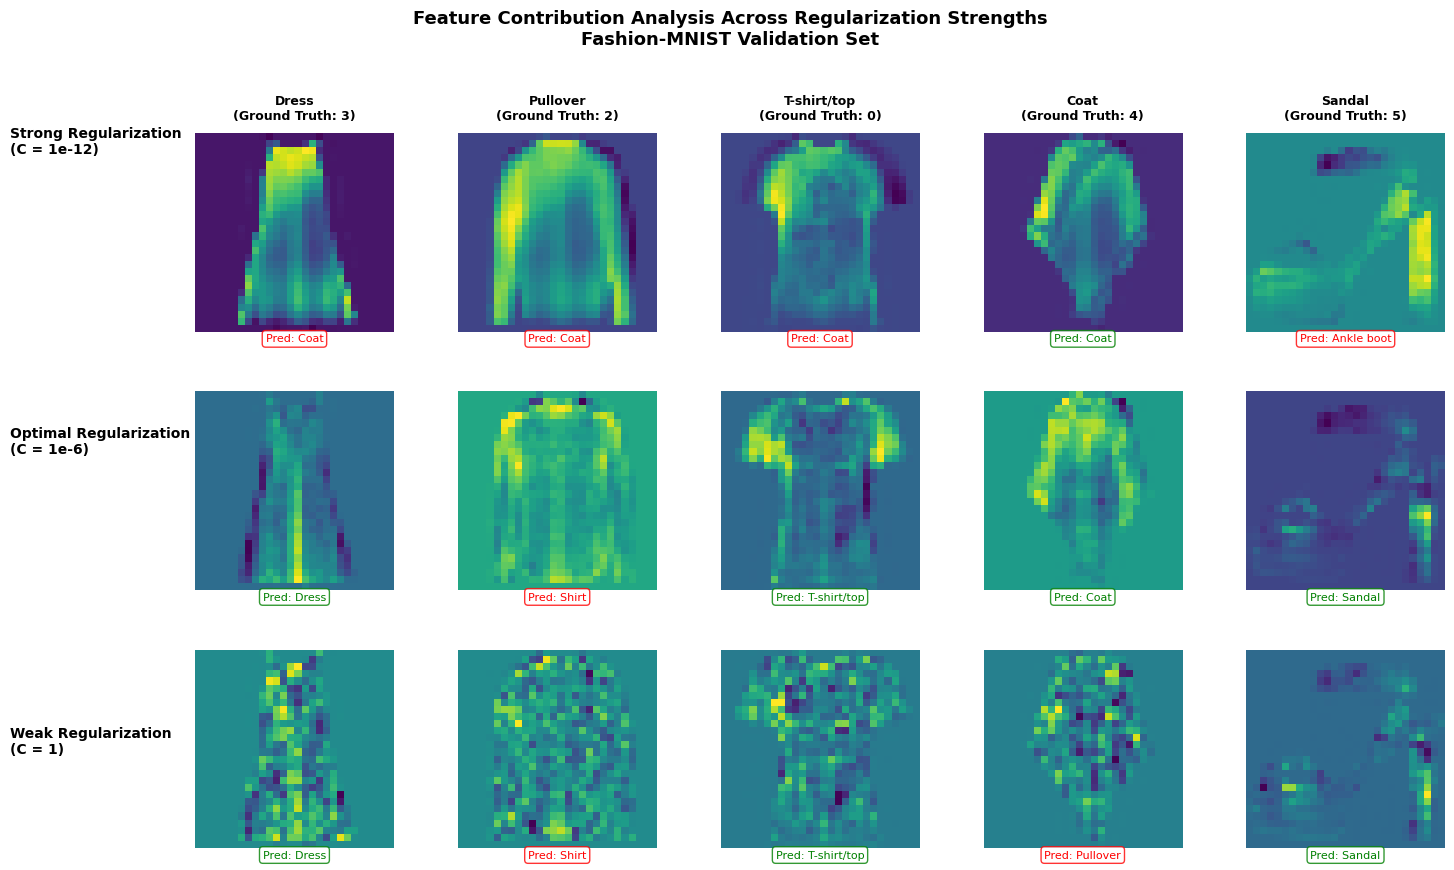

With minimal regularization, the model overfits to training-specific noise rather than learning generalizable features


In [ ]:
# Fashion-MNIST class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# pick 5 validation images (same images for all C)
idx = [0, 1, 2, 3, 4]

X_vis = X_val[idx]
y_vis = y_val[idx]

C_values = [
    ("Strong Regularization\n(C = 1e-12)", 1e-12),
    ("Optimal Regularization\n(C = 1e-6)", 1e-7),
    ("Weak Regularization\n(C = 1)", 1)
]

models = []

for label, C in C_values:
    clf = LogisticRegression(
        solver="lbfgs",
        C=C,
    )
    clf.fit(X_train, y_train)
    models.append((label, clf))

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(
    nrows=len(models),
    ncols=len(X_vis),
    figsize=(15, 9)
)

for row, (label, clf) in enumerate(models):
    preds = clf.predict(X_vis)

    for col in range(len(X_vis)):
        img = X_vis[col]
        pred_class = preds[col]
        true_class = y_vis[col]

        # pixel-wise contribution
        contribution = img * clf.coef_[pred_class]

        ax = axes[row, col]
        im = ax.imshow(
            contribution.reshape(28, 28),
            cmap="viridis"
        )
        ax.axis("off")

        # Column titles with actual class names (only on first row)
        if row == 0:
            ax.set_title(
                f"{class_names[true_class]}\n(Ground Truth: {true_class})",
                fontsize=9,
                fontweight='bold',
                pad=10
            )

        # Add prediction info for ALL rows below each image
        pred_name = class_names[pred_class]
        color = 'green' if pred_class == true_class else 'red'
        ax.text(
            0.5, -0.05,
            f"Pred: {pred_name}",
            transform=ax.transAxes,
            ha='center',
            fontsize=8,
            color=color,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=color)
        )

    # Row labels on the left with better positioning
    fig.text(
        0.02,
        1 - (row + 0.5) / len(models),
        label,
        fontsize=10,
        fontweight='bold',
        va='center',
        ha='left',
        rotation=0
    )

plt.suptitle(
    "Feature Contribution Analysis Across Regularization Strengths\nFashion-MNIST Validation Set",
    fontsize=13,
    fontweight='bold',
    y=0.98
)

# Adjust layout to minimize whitespace
plt.tight_layout(rect=[0.12, 0.02, 1, 0.96])
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()
#"For the strong reg: The model is heavily penalized for using strong weights, so it spreads the decision boundary smoothly across many features."
#"Optimum regularizationallows the model enough flexibility to learn meaningful patterns without overfitting."
print("With minimal regularization, the model overfits to training-specific noise rather than learning generalizable features")

Each heatmap shows which pixels the model considers most important when making a prediction for a specific image. The colors represent the magnitude of contribution:

**For the strong regularization:**

**Visual pattern:** You'll notice relatively uniform, smooth heatmaps with broad, diffuse patterns


**For the optimal regularization:**

**Visual pattern:** Structured, interpretable features that align with the actual garment shape

For T-shirts: contributions focus on the torso and sleeve regions


**Why:** This C value was found through validation - it allows the model enough flexibility to learn meaningful patterns without overfitting


**For the weak regularization:**


**Visual pattern:** Noisy, scattered bright spots throughout the image - the model is picking up on pixel pattern that are quirks specific to individual training examples rather than general patterns.

**Why:** With minimal regularization, the model overfits to training-specific noise rather than learning generalizable features